# Librerias

In [39]:
%config IPCompleter.greedy=True

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import seaborn as sns
from pyodbc import ProgrammingError
from datetime import datetime

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage


from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

import cdx_pilotage.pims_functions as pf
pd.set_option('display.max_columns', None)

# Cargar Raspacrudos

In [54]:
def cargar_raspacrudos(excel, hoja):
 
    df_raspa = pd.read_excel(excel, sheet_name = hoja, header = 1)

    for col in list(df_raspa.columns):
        if df_raspa[col].notnull().sum() == 0:
            df_raspa.drop([col], axis=1, inplace=True)

    df_raspa["Fecha 1"] = pd.to_datetime(df_raspa["Fecha Desc."], format='%Y-%m-%d %H:%M:%S', errors = "coerce")
    df_raspa["Fecha 2"] = pd.to_datetime(df_raspa["Fecha Desc."], format='%d/%m/%Y', errors = "coerce") 
    df_raspa["Fecha Desc."] = df_raspa["Fecha 1"].combine_first(df_raspa["Fecha 2"])
    df_raspa.drop(['Fecha 1', 'Fecha 2'], axis = 1, inplace = True)
        
    print("Cargado df raspa:")
    print(df_raspa.shape)
    display(df_raspa.head(3))
    print("==============================")
    
    return df_raspa

In [55]:
excel_raspa = r"C:\Users\JESCOBARO\Desktop\CDX_PIMS\Raspa Crudos PILOTAGE.xlsm"
hoja_excel = "CRUDOS"

df_raspa = cargar_raspacrudos(excel_raspa, hoja_excel)

Cargado df raspa:
(2298, 61)


,Código Fecha Pedido,Código Fecha,Fecha pedida,Fecha Desc.,Refinería,Crudo,Cantidad,Observaciones,MES ABASTEC,BARCO,ETA,CD,FECHA DESCARGA,CRUDO2,CANTIDAD (t),Estado,API,%S,FAMILIA,FÓRMULA COMPRA \n(PROGRAMA),ESTIMACIÓN FLETE \n(PROGRAMA),FÓRMULA COMPRA \n(BUDGET),ESTIMACIÓN FLETE \n(BUDGET),D FÓRMULA COMPRA,D ESTIMACIÓN FLETE,Cierre,FECHA CARGA,Comentarios,Otros comentarios,DEAL STRATEGY,FECHA COMPRA,LCi,LCf,ETBallegro,ETS,LAi,LAf,ETAallegro,PRICING,Rev PIMS,Inc RGSR,Inc RLR,Tomahawk vigente,FLETE REAL,ESTIMACIÓN COMPRA\n(PIMS),ESTIMACIÓN FLETE\n(PIMS),API*,%S*,en camino,CARGA,DESCARGA,DEMORAS,DEMORAS ($/día),Operador,DESVÍO PEDIDO,DESVÍO ALLEGRO,DESVÍO DESCARGA,ETB-I,ETS-ETB,ETA-ETS,ETD-ETA
0,40701RGSR,40695RGSR,2011-06-07,2011-06-01,RGSR,Kole Marine,110978,Tenerife sp.,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,00:00:00,NaT,NaT,NaT,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-40701.0,0.0,-40701,1778-07-29,0.0,0.0,0.0
1,40701RLR,40695RLR,2011-06-07,2011-06-01,RLR,RUSSIAN EXPORT BLEND,129374,Reef,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,00:00:00,NaT,NaT,NaT,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-40701.0,0.0,-40701,1778-07-29,0.0,0.0,0.0
2,40701RLR,40696RLR,2011-06-07,2011-06-02,RLR,Qua Iboe,122072,Toledo sp.,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,00:00:00,NaT,NaT,NaT,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-40701.0,0.0,-40701,1778-07-29,0.0,0.0,0.0


In [56]:
df_raspa = df_raspa.replace({'Crudo': "Arabia"}, "Arabia Ligero")
df_raspa = df_raspa.replace({'Crudo': "Arabia ligero"}, "Arabia Ligero")
df_raspa = df_raspa.replace({'Crudo': "QUA IBOE"}, "Qua iboe")

In [57]:
df_raspa["Month_order"] = pd.to_datetime(df_raspa["Fecha Desc."], format= '%b-%y')
df_aux = df_raspa[df_raspa["Month_order"] >= "2020-10-01"]
df_aux[(df_aux["Refinería"] == "RGSR") & (df_aux["Crudo"] == "Amenam Blend")]

,Código Fecha Pedido,Código Fecha,Fecha pedida,Fecha Desc.,Refinería,Crudo,Cantidad,Observaciones,MES ABASTEC,BARCO,ETA,CD,FECHA DESCARGA,CRUDO2,CANTIDAD (t),Estado,API,%S,FAMILIA,FÓRMULA COMPRA \n(PROGRAMA),ESTIMACIÓN FLETE \n(PROGRAMA),FÓRMULA COMPRA \n(BUDGET),ESTIMACIÓN FLETE \n(BUDGET),D FÓRMULA COMPRA,D ESTIMACIÓN FLETE,Cierre,FECHA CARGA,Comentarios,Otros comentarios,DEAL STRATEGY,FECHA COMPRA,LCi,LCf,ETBallegro,ETS,LAi,LAf,ETAallegro,PRICING,Rev PIMS,Inc RGSR,Inc RLR,Tomahawk vigente,FLETE REAL,ESTIMACIÓN COMPRA\n(PIMS),ESTIMACIÓN FLETE\n(PIMS),API*,%S*,en camino,CARGA,DESCARGA,DEMORAS,DEMORAS ($/día),Operador,DESVÍO PEDIDO,DESVÍO ALLEGRO,DESVÍO DESCARGA,ETB-I,ETS-ETB,ETA-ETS,ETD-ETA,Month_order
2065,44121RGSR,44122RGSR,2020-10-17,2020-10-18,RGSR,Amenam Blend,130000,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,00:00:00,NaT,NaT,NaT,00:00:00,2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-44121.0,0.000000,-44121,1778-07-29,0.0,0.000000,0.000000,2020-10-18
2072,44141RGSR,44141RGSR,2020-11-06,2020-11-06,RGSR,Amenam Blend,130000,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,00:00:00,NaT,NaT,NaT,00:00:00,2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-44141.0,0.000000,-44141,1778-07-29,0.0,0.000000,0.000000,2020-11-06
2122,44252RGSR,44250RGSR,2021-02-25,2021-02-23,RGSR,Amenam Blend,124285,Se cierra con una ventana de descarga 29-03/Ma...,febrero,FRONT SIENA,2021-02-01 00:00:00,24-26,2021-02-23,AMENAM BLEND,124285.000,(D),38.98,0.09,Light Sweet IMO,"BR + 0,81",NaN,"BR +0,6",0.98,NaN,-0.98,Cerrado.,NaT,Fondeado.,NaN,NaN,NaN,NaT,NaT,00:00:00,1900-01-01 12:00:00,NaT,NaT,00:00:00,NaN,FEB21_5,0.009139,0.009139,NaN,NaN,NaN,NaN,4.844629e+06,11185.65000,?,44228.000000,22.000000,NaN,NaN,NaN,-44252.0,44228.000000,-2,1778-07-29,1.5,44226.500000,22.000000,2021-02-23
2180,44354RGSR,44356RGSR,2021-06-07,2021-06-09,RGSR,Amenam Blend,124657.854,NaN,junio,FRONT THOR,2021-06-05 00:00:00,NaN,2021-06-09,AMENAM BLEND,124657.854,(D),38.98,0.09,Light Sweet IMO,"BR - 0,99",0.82,"BR +0,6",0.98,-1.59,-0.16,Cerrado.,2021-05-22,NaN,NaN,103328.0,2021-04-29 00:00:00,2021-05-22,2021-05-23,2021-05-22 12:00:00,2021-05-23 12:00:00,2021-06-06,2021-06-07,2021-06-06 12:00:00,15 -21 Mayo,JUN21_4,-0.606316,-0.606316,NaN,NaN,NaN,NaN,4.859163e+06,11219.20686,LLEGÓ,14.000000,4.000000,NaN,NaN,César González,-0.5,-1.500000,2,1899-12-20,1.5,12.500000,4.000000,2021-06-09
2211,44415RLR,44401RGSR,2021-08-07,2021-07-24,RGSR,Amenam Blend,125129,Destilable solo,julio,FRONT ODIN,2021-07-24 04:00:00,NaN,2021-07-24,AMENAM BLEND,125129.000,(C),38.98,0.09,Light Sweet IMO,BR + 0,NaN,"BR +0,6",NaN,NaN,NaN,Cerrado.,2021-07-10,Intercambiado a RLR por el Qua de Agosto por r...,NaN,103501.0,2021-06-15 00:00:00,2021-07-08,2021-07-09,2021-07-08 12:00:00,2021-07-08 00:00:00,2021-08-01,2021-08-02,2021-08-01 12:00:00,5 Bus days after BOL DATE,JUL21_2,-0.523512,-0.523512,NaN,CFR,NaN,NaN,4.877528e+06,11261.61000,LLEGÓ,14.166667,-0.166667,NaN,22500.0,NaN,-5.5,-8.333333,-14,1900-02-08,-2.0,16.166667,-0.166667,2021-07-24


In [156]:
df_aux = df_raspa[(df_raspa["Month_order"] >= "2020-10-01") & (df_raspa["Month_order"] <= "2021-09-01")]
df_aux = df_aux[df_aux["Refinería"].isin(["RGSR"])]
df_aux = pd.DataFrame(df_aux.groupby(["Refinería", "Crudo"])["Cantidad"].sum()).sort_values(by=["Refinería", "Cantidad"], ascending = False)
df_aux = df_aux.round(0)
df_aux

Cantidad
Refinería Crudo                              
RGSR      Arabia Ligero             1606029.0
          Escravos                  1038271.0
          Forcados                   657946.0
          Amenam Blend               634072.0
          Buzios                     541873.0
          Bonga                      402679.0
          Pennington                 390899.0
          Akpo                       388540.0
          Qua iboe                   371589.0
          Saharan Blend              357633.0
          EBCO                       345832.0
          Azeri                      259898.0
          Agbami                     242425.0
          Brega                      240657.0
          Okoro light                220322.0
          Lokele                     189541.0
          WTI Light                  181667.0
          CJ Blend                   175893.0
          Mezcla de Crudo Saldanha   140689.0
          Jones Creek                136097.0
          Troll Blend                134791.0
          Erha                       127748.0
          Egina                      126989.0
          Yoho                       123692.0
          WTL                         94391.0
          TI CACTUS                   90913.0
          West Texas Cactus           90206.0
          Okwori                      86886.0
          Mellitah                    77044.0
          ATAPU                       70794.0
          SURURU                      67133.0
          Otakikpo                    63752.0
          TI Epic/GrayOak             63562.0
          OKONO                       32637.0

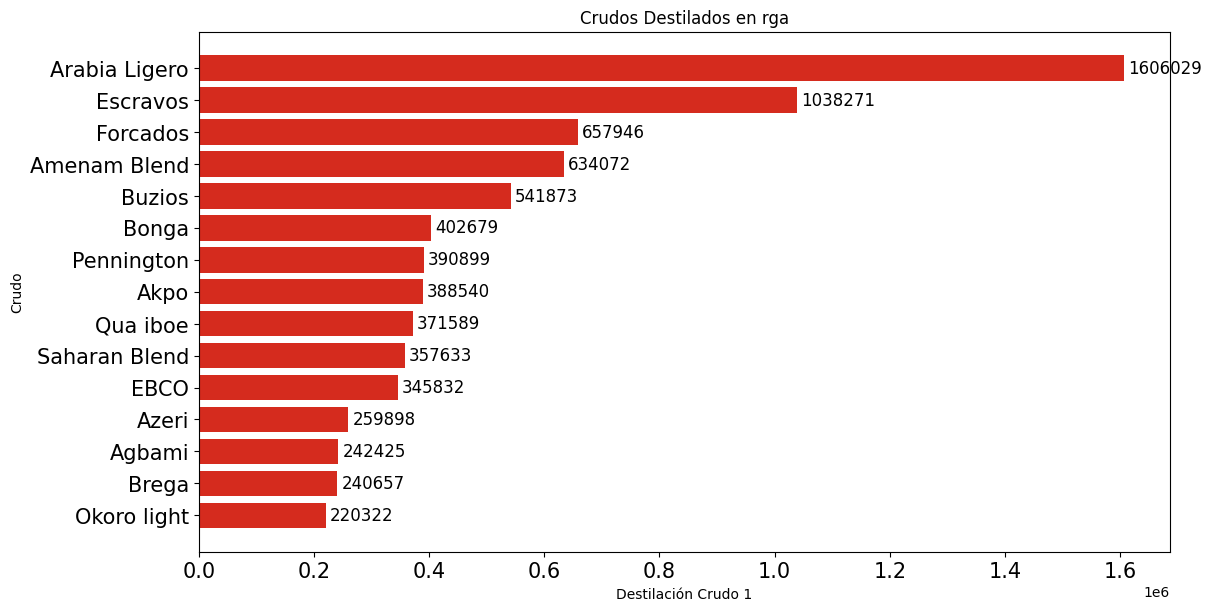

In [159]:
df_plot = df_aux.reset_index().sort_values(by = "Cantidad").tail(15)
fig, ax = plt.subplots(figsize = (12, 6), constrained_layout = True)
ax.barh(df_plot.Crudo, df_plot.Cantidad, color = "#E54F44")
refineria = "rga"
ax.set_title(f"Crudos Destilados en {refineria}")
ax.set_ylabel("Crudo")
ax.set_xlabel("Destilación Crudo 1")
ax.tick_params(axis="both", labelsize = 15)
ax.bar_label(ax.containers[0], fmt='%.0f', padding = 3, fontsize = 12)
plt.show();

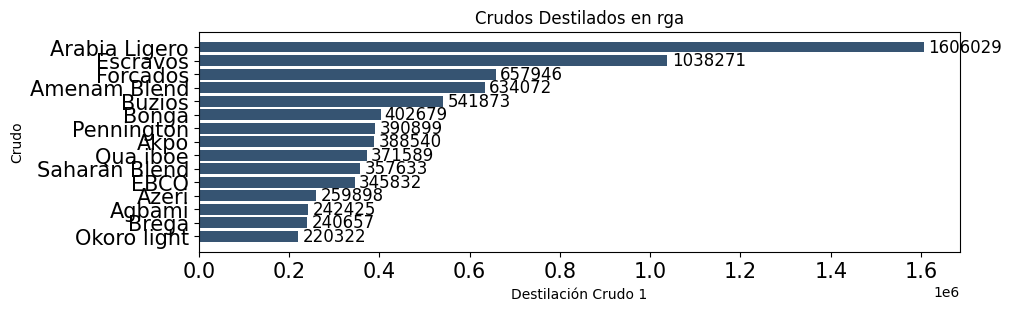

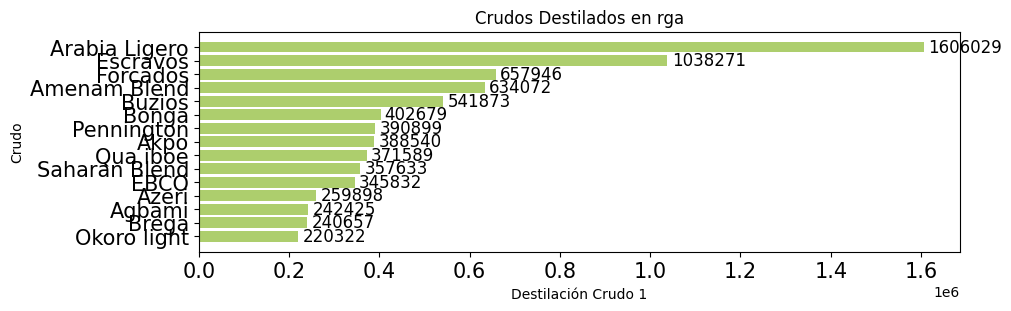

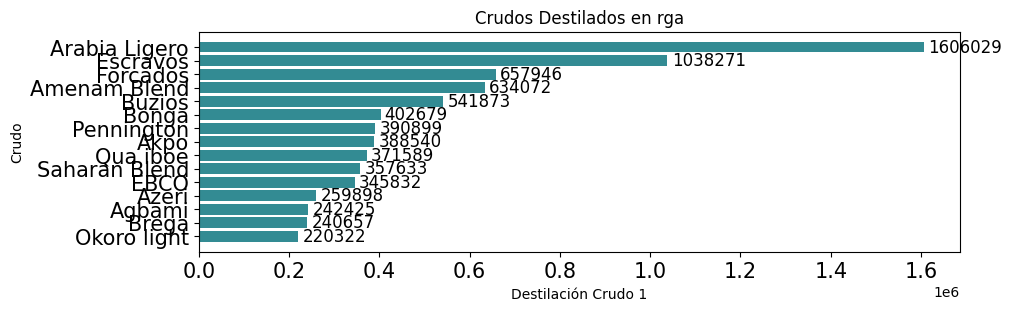

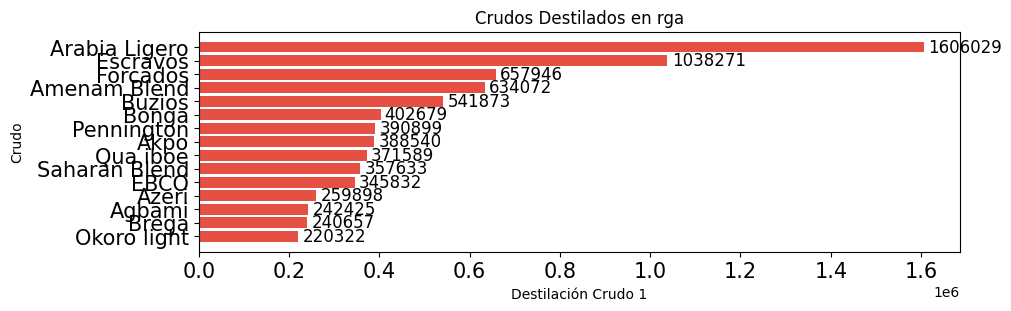

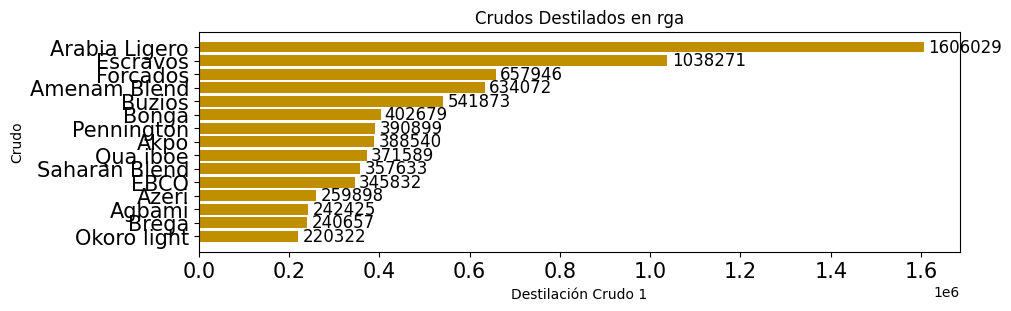

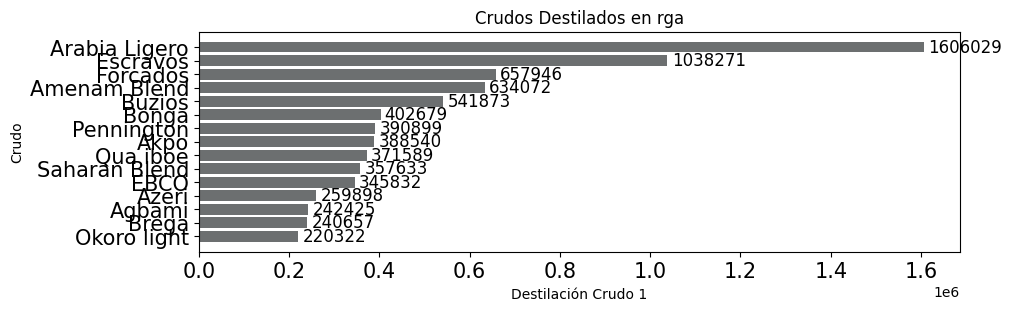

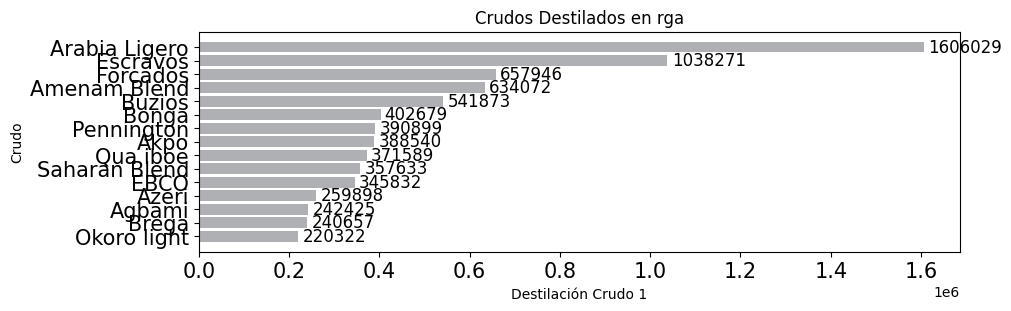

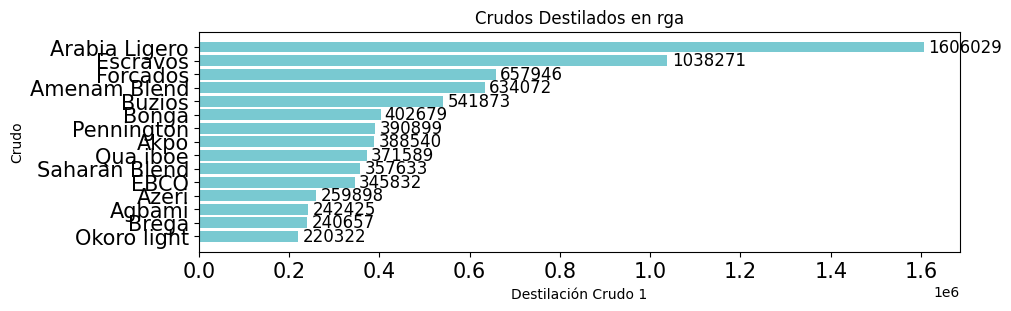

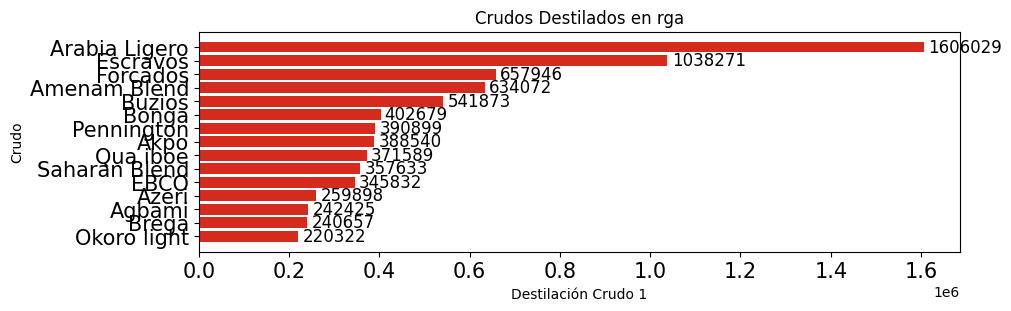

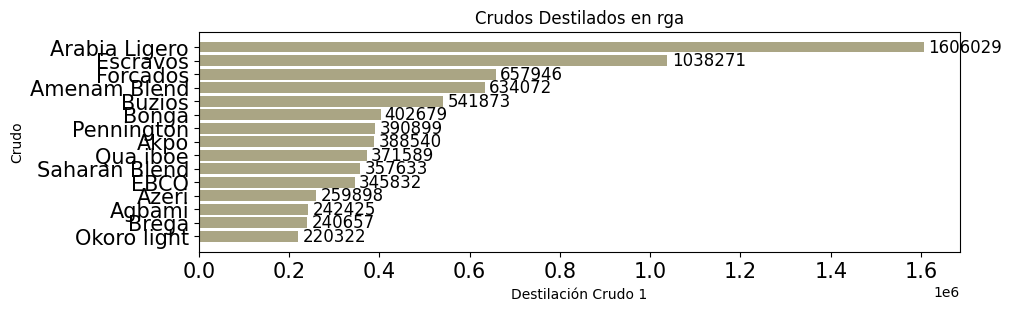

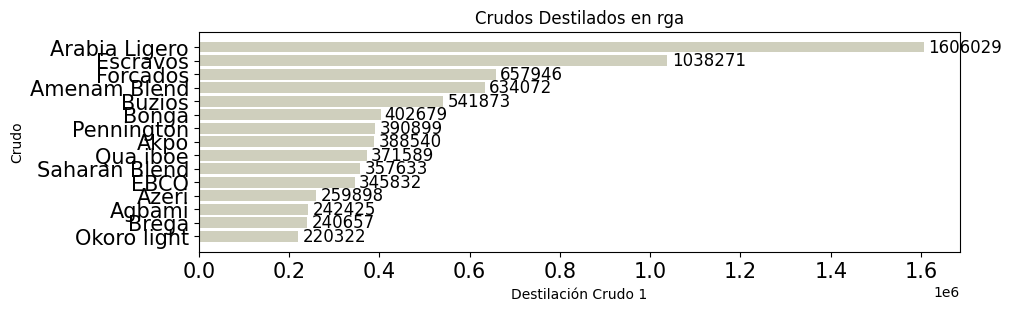

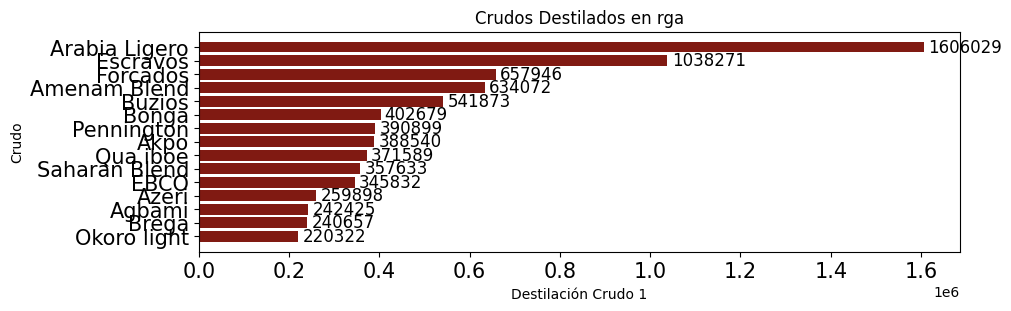

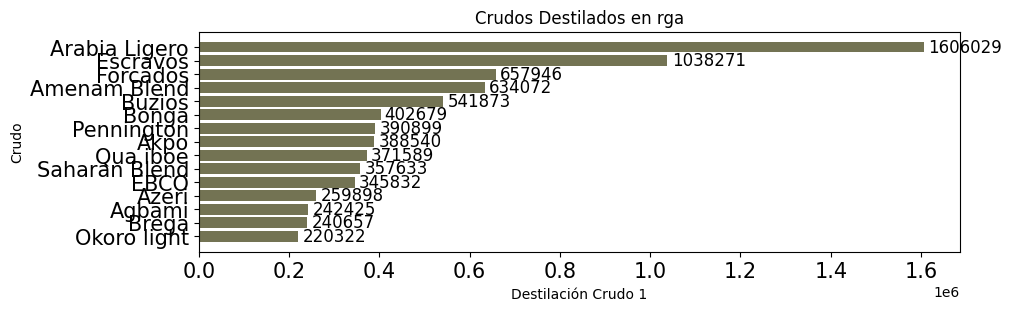

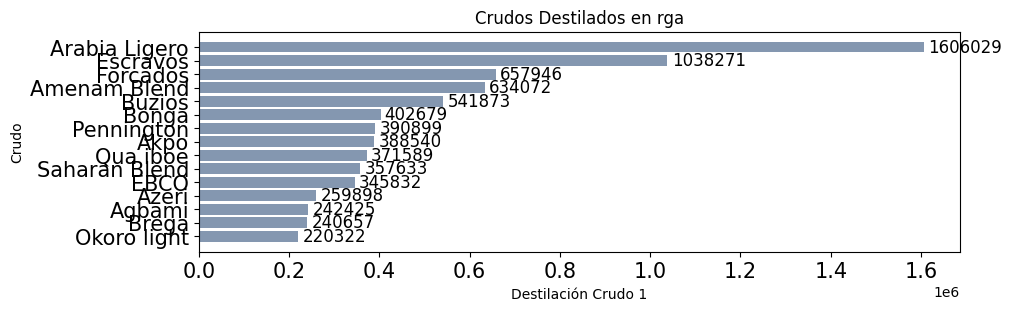

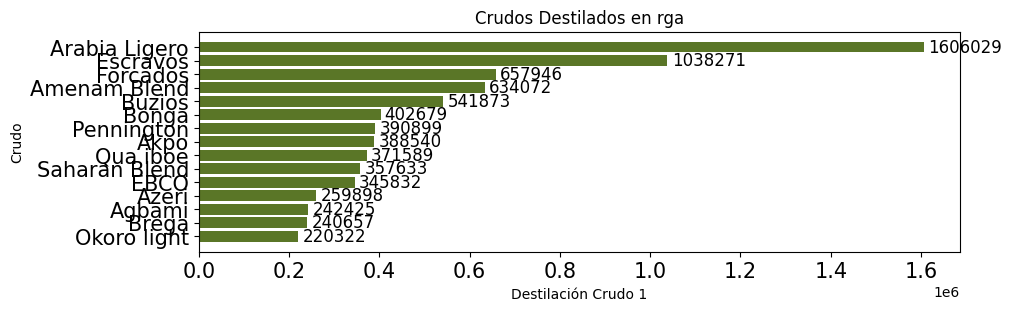

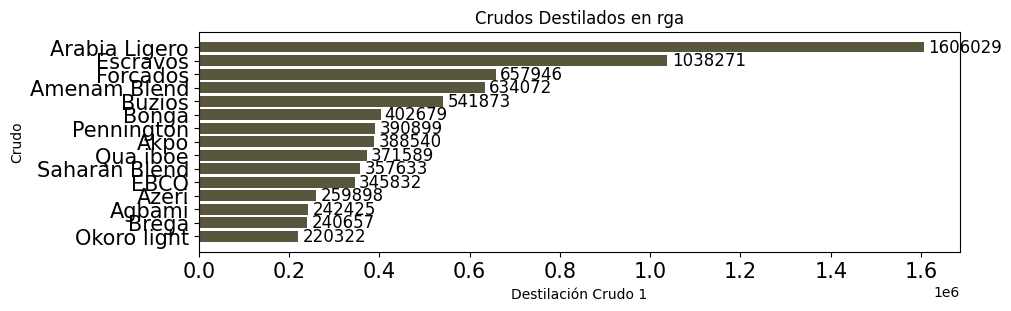

In [160]:
colores_cepsa = ["#365472", "#ADCE6D", "#338B93", "#E54F44",
                 "#BF8F00", "#6C6F70", "#AEB0B3", "#79C9D1", 
                 "#D52B1E", "#AAA584", "#CFCFBD", "#801A12", 
                 "#737353", "#8497B0", "#5A7627", "#59563E"]
    
for color in colores_cepsa:
    df_plot = df_aux.reset_index().sort_values(by = "Cantidad").tail(15)
    fig, ax = plt.subplots(figsize = (10, 3), constrained_layout = True)
    ax.barh(df_plot.Crudo, df_plot.Cantidad, color=color)
    refineria = "rga"
    ax.set_title(f"Crudos Destilados en {refineria}")
    ax.set_ylabel("Crudo")
    ax.set_xlabel("Destilación Crudo 1")
    ax.tick_params(axis="both", labelsize = 15)
    ax.bar_label(ax.containers[0], fmt='%.0f', padding = 3, fontsize = 12)
    plt.show();

# Dendogram Assay CD1

In [4]:
def cargar_excel_assays_crudos(excel, hoja):
 
    df_assays = pd.read_excel(excel, sheet_name = hoja, header = 6)

    for col in list(df_assays.columns):
        if df_assays[col].notnull().sum() == 0:
            df_assays.drop([col], axis=1, inplace=True)

    df_assays = df_assays[df_assays["TEXT"].notnull()]

    print("Cargado df assays:")
    print(df_assays.shape)
    display(df_assays.head(10))
    print("==============================")
    
    return df_assays

In [5]:
excel_assays = r"C:\Users\JESCOBARO\Desktop\CDX_PIMS\GlobalModel_CEPSA_2.12\Algeciras\Algeciras Assays.xlsx"
hoja_excel_SCD2 = "ASSAYS1"

df_assays_cd1 = cargar_excel_assays_crudos(excel_assays, hoja_excel_SCD2)

Cargado df assays:
(519, 161)


,ROWNAMES,TEXT,!*?,!Type,!Prop,!Lookup,!Stream,!Sheet,!Lookup.1,ARI,ASG,ABO,AGB,AJE,AKP,ALJ,AVH,AMB,AXN,ANT,ARL,ARM,ASE,ATA,AZE,NOD,BAL,BAP,BAU,BLA,BON,BOL,BRR,BGA,BBB,BMS,BUA,BUZ,CAE,CEB,CHE,CJB,CLA,CLO,CPB,DAL,DAB,DJE,DSW,DUC,CEP,EAF,E44,E46,KIR,EBO,EGI,EKO,ENT,ERH,ESH,ESS,ESC,ESP,FLG,FOR,FRL,FOB,GKR,GDG,GIR,GLT,GRA,GUA,GUL,HIB,IRA,IRL,IRP,IST,JSV,JON,JUB,KIB,KOL,KOM,KUE,LAE,LIV,LOK,LUB,LUL,MAN,MAR,MAY,MDN,MEL,MRO,ME3,MUR,NEM,NKO,OGU,OKO,OKR,OKW,OBE,OLE,OME,OSE,OTA,PAZ,PEN,PIE,PLU,QAR,QUI,RAB,REB,SAB,SKF,SAP,SMS,SAT,SA1,SCH,SIL,SIR,SNG,SOR,STA,SUR,TEN,TER,TIE,TIP,TRO,UZE,URL,USB,VAR,VAS,WTC,WML,WCS,WED,WHC,WHR,WTL,YOH,ZAB,ZAE,ZAR,ZUE,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160
0,*,Name,NaN,1,NaN,NaN,NaN,NaN,NaN,Atm. Res. Imported,AASGARD BLEND,ABO,AGBAMI,AJE,AKPO,AL JURF,ALVHEIMBLEND,AMENAM BLEND,AMNA,ANTAN,ARABIA LIGERO,ARABIA MEDIO,ASENG,ATAPU,Azeri CIC 2020,BAKKEN,BASRA LIGERO,BASRAH PESADO,BAUNA,BLACKHAWK,BONGA,BONNY LIGERO,BRASS RIVER,BREGA,BRENT BLEND,BRYAN MOUND,BU ATTIFEL,BUZIOS,CABINDA EXPORT,CEIBA BLEND,CHELEKEN,CJ Blend,CLAIR,Clov,CPC BLEND,Dalia,DAS BLEND CI,DJENO,DOMESTIC SWEET,DUC,EA,EAGLE FORD,Eagle Ford 44,Eagle Ford 45,EBCO,EBOME,EGINA,EKOFISK,ENTERPRISE,ERHA,ES Sharara,ES SIDER,ESCRAVOS,ESPOIR,Flotta Gold,FORCADOS,FORCADOS LIGHT,FORTIES BLEND,GINA KROG,GINDUNGO,GIRASSOL,GOLIAT BLEND,GRANE BLEND,GUAFITA,Gullfaks,HIBERNIA,IRACEMA,IRAN LIGERO,IRAN PESADO,ISTMO 32,Johan Sverdrup,JONES CREEK,Jubilee Blend,Kissanje Blend,KOLE,KOLE MARINE,KUWAIT EXPORT,LAVAN EXPORT,LIVERPOOL BLEND,LOKELE,LUCINA BLEND,LULA,MANDJI,MARS,MAYA,MEDANITO,MELLITAH,MERO,MESA 30,Murban Exp. Bld,NEMBA,Nkossa,OGUENDJO,OKONO,OKORO LIGHT,OKWORI,OKWUIBOME,OLOMBENDO,OMAN EXPORT,OSEBERG,OTAKIKPO,Pazflor,PENNINGTON,PIERCE,PLUTONIO,QARUN,QUA IBOE,RABI BLEND,RUSSIAN EXPORT BLEND,SAHARAN BLEND,SANKOFA,SAPINHOA,SARIR,SATURNO,SAXI BLEND,Schiehallion,SIBERIAN LIGHT,SIRRI,SONGKLA,SOROOSH,STATFJORD,SURURU,TEN BLEND,TERRA NOVA,TI Epic/GrayOak,TI Permian,TROLL BLEND,Upper Zakum Exp Bl,URAL LIGERO,USAN Blend,VARANDEY,VASCONIA,WEST TEXAS CACTUS,West Texas Light 46.3,Western Canad'n Select,WESTERN DESERT,WHITE CLIFFS,WHITE ROSE,WTI LIGHT,YOHO,ZAFIRO BLEND,ZAIRE EXPORT,ZARZAITINE,ZUEITINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*,Reference,NaN,2,NaN,NaN,NaN,NaN,NaN,,CEPSA AASGARD BLEND,CEPSA ABO,CEPSA AGBAMI,CEPSA AJE,CEPSA AKPO,CEPSA AL JURF,CEPSA ALVHEIMBLEND,CEPSA AMENAM,CEPSA AMNA,CEPSA ANTAN,CEPSA ARABIA LIGERO,CEPSA ARABIA MEDIO,CEPSA ASENG,CEPSA ATAPU,Azeri CIC 2020,CEPSA BAKKEN,CEPSA BASRA LIGERO,CEPSA BASRAH PESADO,CEPSA BAUNA,CEPSA BLACKHAWK,CEPSA BONGA,CEPSA BONNY LIGERO,CEPSA BRASS RIVER,CEPSA BREGA,CEPSA BRENT BLEND,CEPSA BRYAN MOUND,CEPSA BU ATTIFEL,CEPSA BUZIOS,CEPSA CABINDA EXPORT,CEPSA CEIBA BLEND,CEPSA CHELEKEN,CJ Blend,Cepsa CLAIR,Cepsa Clov,CEPSA CPC BLEND,CEPSA DALIA Tfe,CEPSA DAS BLEND CI,CEPSA DJENO,CEPSA DOMESTICSWEET,CEPSA DUC,CEPSA EA,CEPSA EAGLE FORD,CEPSA EAGLE FORD 44,CEPSA Eagle Ford 45,CEPSA EBCO,CEPSA EBOME,CEPSA EGINA,Cepsa EKOFISK,CEPSA ENTERPRISE,CEPSA ERHA,CEPSA Es Sharara,CEPSA ES SIDER,ESCRV322,CEPSA ESPOIR,CEPSA Flotta Gold,CEPSA FORCADOS,CEPSA FORCADOS LIGHT,CEPSA FORTIES BLEND,CEPSA GINA KROG,CEPSA GINDUNGO,CEPSA GIRASSOL,CEPSA GOLIAT BLEND,CEPSA GRANE BLEND,CEPSA GUAFITA,CEPSA GULLFAKS,CEPSA HIBERNIA,Cepsa Iracema,CEPSA IRAN LIGERO,CEPSA IRAN PESADO,CEPSA ISTMO 32,CEPSA JOHAN SVERDRUP,CEPSA JONES CREEK,CEPSA Jubilee Blend,Cepsa Kissanje Blend,CEPSA KOLE,CEPSA KOLE MARINE,CEPSA KUWAIT EXPORT,CEPSA LAVAN EXPORT,CEPSA LIVERPOOL BLEND,CEPSA LOKELE,CEPSA LUCINA BLEND,CEPSA LULA,CEPSA MANDJI,CEPSA MARS,CEPSA MAYA,CEPSA MEDANITO,CEPSA MELLITAH,CEPSA MERO,CEPSA MESA 30,CEPSA Murban Exp. Bld,CEPSA NEMBA,Cepsa Nkossa,CEPSA OGUENDJO (c),CEPSA OKONO,CEPSA OKORO LIGHT,CEPSA OKWORI,CEPSA OKWUIBOME,CEPSA OLOMBENDO,CEPSA OMAN EXPORT,CEPSA OSEBERG,CEPSA OTAKIKPO,Cepsa PAzflor,CEPSA PENNINGTON,CEPSA PIERCE,CEPSA PLUTONIO,CEPSA QARUN NEW,CEPSA QUA IBOE,CEPSA RABI BLEND,CEPSA RUSSIAN EXPORT BLEND,CEPSA S

In [ ]:
# excel_assays = r"C:\Users\JESCOBARO\Desktop\CDX_PIMS\GlobalModel_CEPSA_2.12\Algeciras\Algeciras Assays.xlsx"
# hoja_excel_SCDb = "ASSAYS2"

# df_assays_cd3 = cargar_excel_assays_crudos(excel_assays, hoja_excel_SCDb)

In [75]:
tags_crudos = ['ABO', 'AGB', 'AJE', 'AKP', 'AMB', 'ATA', 'AZE', 'BAU', 'BGA', 'BOL', 'BON',
              'BUZ', 'CAE', 'CEP', 'CJB', 'E44', 'E46', 'EGI', 'ERH', 'ESC', 'ESH', 'FOR',
              'GUL', 'IRA', 'JON', 'LIV', 'LOK', 'MEL', 'MRO', 'NKO', 'NOD', 'OBE', 'OKO', 
              'OKR', 'OKW', 'OTA', 'PEN', 'QAR', 'QUI', 'SAB', 'SAP', 'SKF', 'SUR', 'TIE', 
              'TIP', 'TRO', 'WML', 'WTC', 'WTL', 'YOH', 'ZAB']

properties_columns = ["TEXT", "Name", "Reference", "API", "Den@15°C(g/cc)", "Sul(%w)","Overhead", "OH/KNA Swing", "Kero Naphtha",
                      "Kerosene","KE/GL Swing","Light Gasoil","LGL/GP Swing","Atmospheric Gasoil","Atmospheric Residue"]

In [76]:
df = df_assays_cd1[["TEXT"] + tags_crudos]
df = df.transpose().reset_index()
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df[properties_columns]
df = df.T.reset_index().drop_duplicates(subset = 0, keep = "first").T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df.head(3)

,TEXT,Name,Reference,API,Den@15°C(g/cc),Sul(%w),Overhead,OH/KNA Swing,Kero Naphtha,Kerosene,KE/GL Swing,Light Gasoil,LGL/GP Swing,Atmospheric Gasoil,Atmospheric Residue
1,ABO,ABO,CEPSA ABO,40.7,0.8211,0.1,0.284207,0.020301,0.03413,0.095517,0.011388,0.319551,0.004254,0.049689,0.180964
2,AGB,AGBAMI,CEPSA AGBAMI,0.04,0.7868,0.04,0.321019,0.02332,0.042101,0.097527,0.011595,0.319068,0.004064,0.045924,0.135381
3,AJE,AJE,CEPSA AJE,41.5,0.8174,0.03,0.199575,0.015355,0.028416,0.050971,0.009326,0.388061,0.005304,0.065429,0.237562


In [14]:
cols_number = df.columns.tolist()
cols_number.remove("TEXT")
cols_number.remove("Name")
cols_number.remove("Reference")

df_2 = df[cols_number].apply(pd.to_numeric)
df_2.dtypes

0
API                    float64
Den@15°C(g/cc)         float64
Sul(%w)                float64
Overhead               float64
OH/KNA Swing           float64
Kero Naphtha           float64
Kerosene               float64
KE/GL Swing            float64
Light Gasoil           float64
LGL/GP Swing           float64
Atmospheric Gasoil     float64
Atmospheric Residue    float64
dtype: object

## Escalado Normalize

In [49]:
data_scaled = normalize(df_2[cols_number])
data_scaled = pd.DataFrame(data_scaled, columns=cols_number, index=df.TEXT)

print("Mean :", data_scaled.API.mean())
print("Max :", data_scaled.API.max())
print("Min :", data_scaled.API.min())
print("Std :", data_scaled.API.std())
data_scaled.head(3)

Mean : 0.6985370813449169
Max : 0.99981893592869
Min : 0.042379506884069953
Std : 0.3992914297629417


,API,Den@15°C(g/cc),Sul(%w),Overhead,OH/KNA Swing,Kero Naphtha,Kerosene,KE/GL Swing,Light Gasoil,LGL/GP Swing,Atmospheric Gasoil,Atmospheric Residue
TEXT,,,,,,,,,,,,
ABO,0.999724,0.020169,0.002456,0.006981,0.000499,0.000838,0.002346,0.000280,0.007849,0.000104,0.001221,0.004445
AGB,0.043145,0.848661,0.043145,0.346259,0.025154,0.045411,0.105195,0.012507,0.344154,0.004384,0.049535,0.146025
AJE,0.999732,0.019691,0.000723,0.004808,0.000370,0.000685,0.001228,0.000225,0.009348,0.000128,0.001576,0.005723


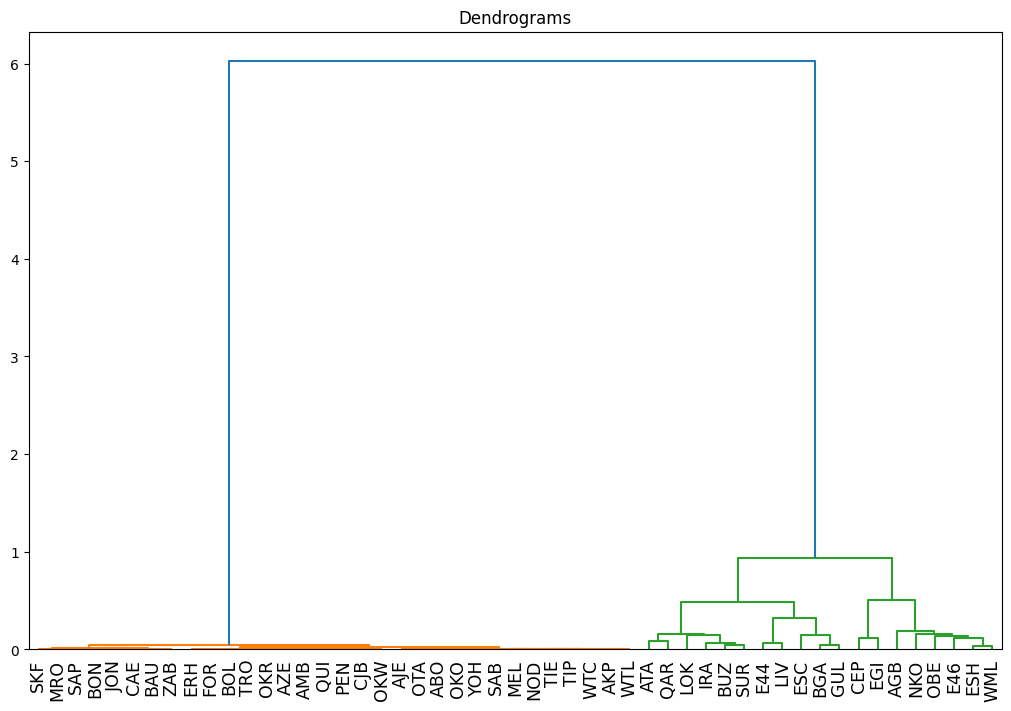

In [50]:
fig, ax = plt.subplots(figsize = (10, 7), constrained_layout = True)
ax.set_title("Dendrograms")  
dend = dendrogram(linkage(data_scaled, method='ward'), labels = data_scaled.index)
# ax.set_ylim(0, 1)
ax.tick_params(axis="x",labelsize = 12.5)
plt.show();

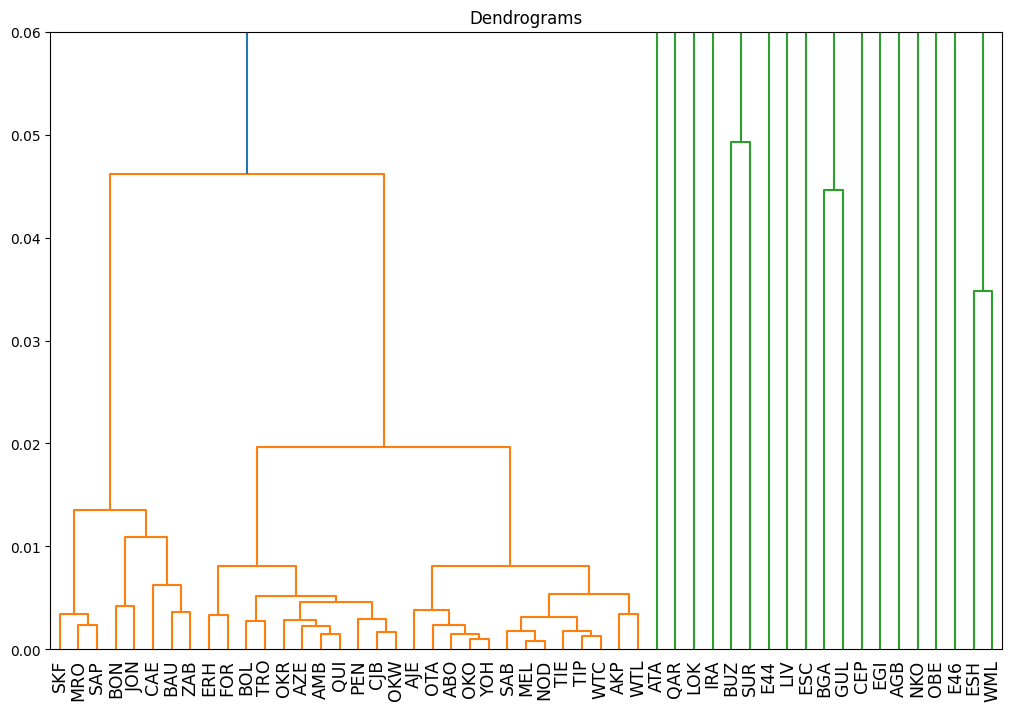

In [51]:
fig, ax = plt.subplots(figsize = (10, 7), constrained_layout = True)
ax.set_title("Dendrograms")  
dend = dendrogram(linkage(data_scaled, method='ward'), labels = data_scaled.index)
ax.set_ylim(0, 0.06)
ax.tick_params(axis="x",labelsize = 12.5)
plt.show();

## Escalado StandardScaler

In [52]:
scaler = StandardScaler(with_mean = True, with_std = True)
scaler.fit(df_2[cols_number])
data_scaled = pd.DataFrame(scaler.transform(df_2[cols_number]), columns=cols_number, index=df.TEXT)

print("Mean :", data_scaled.API.mean())
print("Max :", data_scaled.API.max())
print("Min :", data_scaled.API.min())
print("Std :", data_scaled.API.std())
data_scaled.head(3)

Mean : 9.251858538542972e-17
Max : 1.3405517420600506
Min : -1.2698662476523366
Std : 1.0099504938362078


,API,Den@15°C(g/cc),Sul(%w),Overhead,OH/KNA Swing,Kero Naphtha,Kerosene,KE/GL Swing,Light Gasoil,LGL/GP Swing,Atmospheric Gasoil,Atmospheric Residue
TEXT,,,,,,,,,,,,
ABO,0.915875,-0.570476,-0.660773,0.942146,0.483928,0.009110,1.324758,1.202235,0.304915,-0.604457,-1.002916,-1.037351
AGB,-1.269866,-1.646184,-1.238890,1.413881,1.116495,1.039584,1.434986,1.325032,0.297438,-0.809869,-1.303601,-1.472495
AJE,0.958880,-0.686515,-1.335243,-0.142393,-0.552139,-0.729501,-1.118098,-0.021071,1.365524,0.534419,0.254287,-0.497056


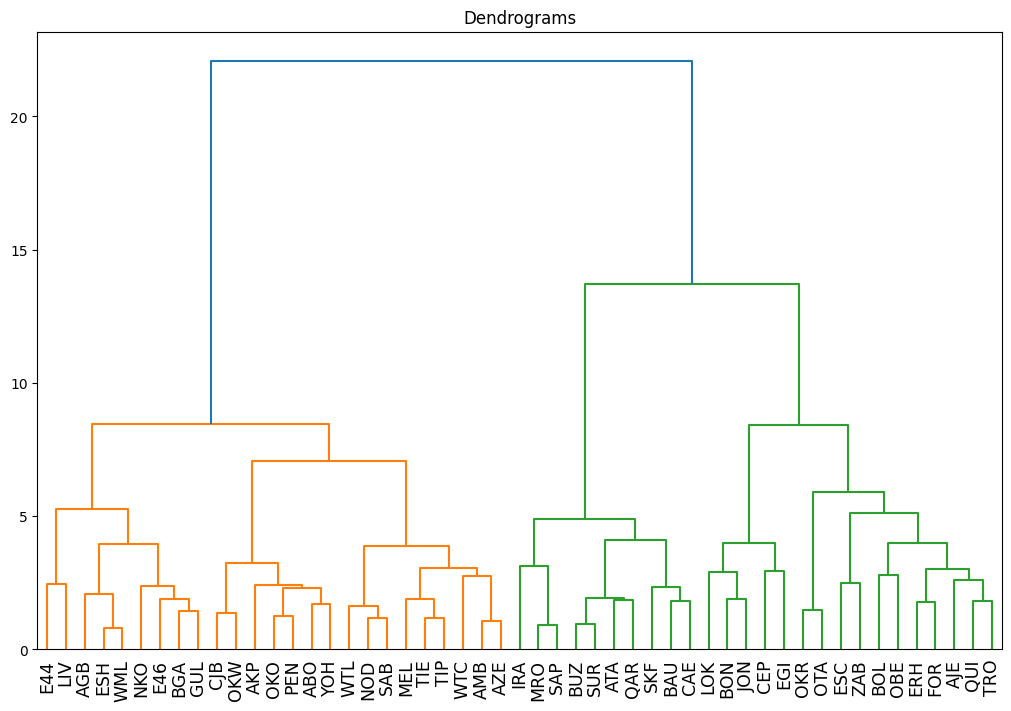

In [53]:
fig, ax = plt.subplots(figsize = (10, 7), constrained_layout = True)
ax.set_title("Dendrograms")  
dend = dendrogram(linkage(data_scaled, method='ward'), labels = data_scaled.index)
# ax.set_ylim(0, 1)
ax.tick_params(axis="x",labelsize = 12.5)
plt.show();

In [46]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=X_scaled)

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=X_scaled)

In [ ]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

In [48]:
cols_number = df.select_dtypes('number').columns.tolist()
X_scaled = scale(df[cols_number])

ValueError: at least one array or dtype is required